In [0]:
#@title Download dataset

from google.colab import files
files.upload()

In [0]:
import pandas as pd
import numpy as np

import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
train_df = pd.read_csv("training.csv")
test_df = pd.read_csv("predict.csv")

In [4]:
train_df.shape

(9418, 72)

In [5]:
train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_gender,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_focus,poster_order,poster_influence,participant1_id,participant1_action,participant1_gender,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_focus,participant1_order,participant1_influence,participant2_id,participant2_action,participant2_gender,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_focus,participant2_order,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_focus,participant3_order,participant3_influence,participant4_id,participant4_action,participant4_gender,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_focus,participant4_order,participant4_influence,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
0,175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,other,57727,space,0.99973,1,0,1.00000,0,0,0,0,0,1,5,male,1,0,1,marketing,6,0.99962,146,liked,male,1,0,1,marketing,5,0.99899,22636,viewed,male,0,0,1,other,4,0.23077,3080,viewed,male,0,0,1,marketing,3,0.23077,44661,viewed,male,0,0,1,other,2,0.23077,3089,viewed,male,0,0,1,other,1,0.23077,0.73677
1,175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,forum,111913,space,0.99977,0,2,0.12336,0,0,0,1,0,0,146,male,1,0,1,marketing,6,0.99899,13659,commented,male,0,0,0,other,5,0.99756,146,commented,male,1,0,1,marketing,4,0.99899,22636,viewed,male,0,0,1,other,3,0.23077,3080,viewed,male,0,0,1,marketing,2,0.23077,44661,viewed,male,0,0,1,other,1,0.23077,0.78240
2,175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,forum,111913,space,0.99977,0,3,0.12336,0,0,0,1,0,0,146,male,1,0,1,marketing,6,0.99899,13659,commented,male,0,0,0,other,5,0.99756,13,commented,male,1,0,1,marketing,4,0.99895,146,commented,male,1,0,1,marketing,3,0.99899,22636,viewed,male,0,0,1,other,2,0.23077,3080,viewed,male,0,0,1,marketing,1,0.23077,0.82125
3,175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,other,9037,space,0.99949,0,0,0.00000,0,0,0,0,0,0,7,male,1,0,1,marketing,6,0.99886,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522
4,175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,other,9037,space,0.99949,0,0,0.00000,0,0,0,0,0,0,7,male,1,0,1,marketing,6,0.99886,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522


In [0]:
# convert time from milisenconds to seconds for train ds
train_df.posted_time /= 1000
train_df.updated_time /= 1000
train_df.age /= 1000
train_df.updated_age /= 1000

In [0]:
# convert time from milisenconds to seconds for predict ds
test_df.posted_time /= 1000
test_df.updated_time /= 1000
test_df.age /= 1000
test_df.updated_age /= 1000

In [0]:
# func to get raw text with date from seconds
def get_date(secs):
  return datetime.datetime.fromtimestamp(secs).strftime("%A, %d/%m/%Y %H:%M:%S")

# get divided parameters of date, such as year, month, weekday, date(day),  hour, min, secs
def get_date_separated(secs):
  date = datetime.datetime.fromtimestamp(secs)
  return int(date.strftime("%Y")), int(date.strftime("%m")), date.strftime("%A"), int(date.strftime("%d")), int(date.strftime("%H")), int(date.strftime("%M")), int(date.strftime("%S"))

In [0]:
# func to get a correlation of one exact feature to all others
def one_feat_corr(df, feat, corr_type):
  # take corr of one feature to others
  corr = df.corrwith(feat, method=corr_type)
  indx = corr.index
  corr = dict(zip(indx, corr))

  # sort correlations
  sorted_corr = [(k, v) for k, v in sorted(corr.items(), key=lambda item: item[1])]
  return sorted_corr

# **Prediction data analysis**

Here I'll investigate features, that can be used for further development, for instance, creation new variable for representing an age of the post.

In [9]:
test_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_gender,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_focus,poster_order,poster_influence,participant1_id,participant1_action,participant1_gender,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_focus,participant1_order,participant1_influence,participant2_id,participant2_action,participant2_gender,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_focus,participant2_order,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_focus,participant3_order,participant3_influence,participant4_id,participant4_action,participant4_gender,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_focus,participant4_order,participant4_influence,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence
0,273721,1.575530e+09,1.575530e+09,1686166.686,1686166.686,other,57727,space,0.99973,13,7,0,0,1,0,1,0,1,119825,female,1,0,0,other,6,0.99754,5,commented,male,1,0,1,marketing,5,0.99962,129104,commented,female,1,0,0,marketing,4,0.99500,4,commented,male,1,0,1,marketing,3,0.99867,41,commented,male,1,0,1,sales,2,0.99828,7,commented,male,1,0,1,marketing,1,0.99886
1,273985,1.575580e+09,1.575580e+09,1634144.551,1634144.551,other,3201,space,0.99992,4,0,0,0,0,0,0,0,1,119825,female,1,0,0,other,6,0.99754,122534,liked,male,1,0,1,marketing,5,0.99678,10,liked,male,1,0,1,marketing,4,0.99902,7,liked,male,1,0,1,marketing,3,0.99886,5,liked,male,1,0,1,marketing,2,0.99962,22636,viewed,male,0,0,1,other,1,0.23077
2,273750,1.575540e+09,1.575540e+09,1681664.278,1681664.278,other,57727,space,0.99973,2,5,0,0,1,0,1,0,1,129104,female,1,0,0,marketing,6,0.99500,109375,commented,male,1,0,1,marketing,5,0.99715,129104,commented,female,1,0,0,marketing,4,0.99500,4,commented,male,1,0,1,marketing,3,0.99867,108025,commented,male,1,0,0,marketing,2,0.99891,7,commented,male,1,0,1,marketing,1,0.99886
3,273302,1.575370e+09,1.575370e+09,1852590.752,1852590.752,other,126877,space,0.50000,0,2,0,0,0,0,1,0,0,7,male,1,0,1,marketing,6,0.99886,108025,commented,male,1,0,0,marketing,5,0.99891,7,commented,male,1,0,1,marketing,4,0.99886,22636,viewed,male,0,0,1,other,3,0.23077,3080,viewed,male,0,0,1,marketing,2,0.23077,44661,viewed,male,0,0,1,other,1,0.23077
4,273897,1.575560e+09,1.575560e+09,1661083.270,1661083.270,other,57727,space,0.99973,4,5,0,0,0,0,1,0,1,109375,male,1,0,1,marketing,6,0.99715,108025,commented,male,1,0,0,marketing,5,0.99891,5,commented,male,1,0,1,marketing,4,0.99962,129104,commented,female,1,0,0,marketing,3,0.99500,146,commented,male,1,0,1,marketing,2,0.99899,4,commented,male,1,0,1,marketing,1,0.99867


In [10]:
test_df.shape

(100, 71)

In [11]:
get_date(test_df.posted_time[0])

'Thursday, 05/12/2019 07:13:20'

In [12]:
get_date_separated(test_df.posted_time[0])

(2019, 12, 'Thursday', 5, 7, 13, 20)

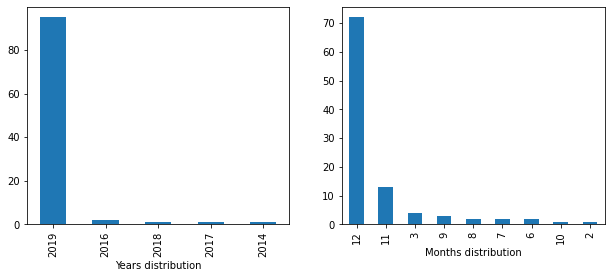

In [13]:
plt.figure(figsize=(16, 4))

plt.subplot(131)
pd.Series([get_date_separated(i)[0] for i in test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Years distribution')

plt.subplot(132)
pd.Series([get_date_separated(i)[1] for i in test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Months distribution')

plt.show()

Text(0.5, 0, 'Hours distribution')

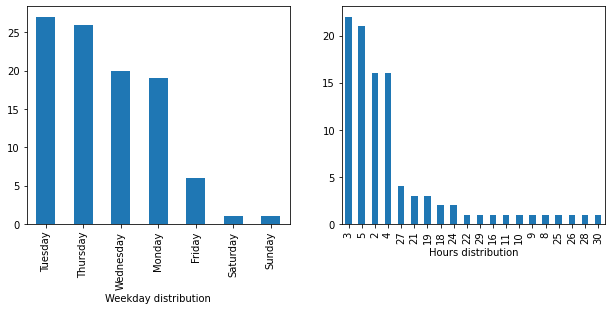

In [14]:
plt.figure(figsize=(16, 4))


plt.subplot(131)
pd.Series([get_date_separated(i)[2] for i in test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Weekday distribution')


plt.subplot(132)
pd.Series([get_date_separated(i)[3] for i in test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution')


In [15]:
filtered_data = [e for e in  filter(lambda x : get_date_separated(x)[0] == 2019, test_df.posted_time)]
len(filtered_data)

95

In [0]:
# remove all dates before 2019 year
new_test_df = test_df[test_df.posted_time.isin(filtered_data)]

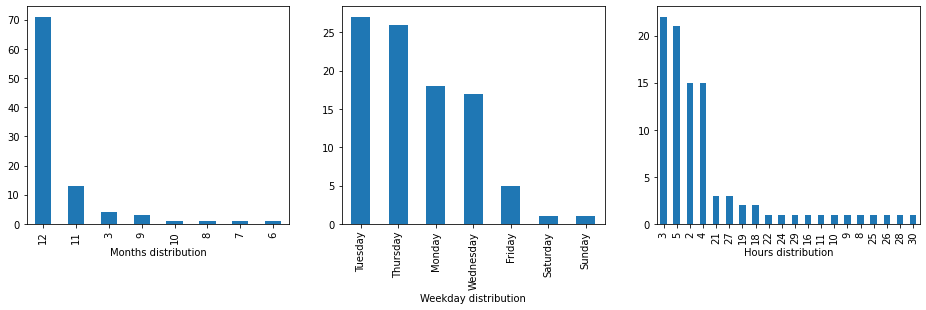

In [17]:
# plot prediction data only for 2019 year 
plt.figure(figsize=(16, 4))

plt.subplot(131)
pd.Series([get_date_separated(i)[1] for i in new_test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Months distribution')

plt.subplot(132)
pd.Series([get_date_separated(i)[2] for i in new_test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Weekday distribution')


plt.subplot(133)
pd.Series([get_date_separated(i)[3] for i in new_test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution')

plt.show()

In [0]:
# filter posted_time for December 2019, month with majority of the posts
december = pd.Series([get_date_separated(e)[3] for e in  filter(lambda x : get_date_separated(x)[1] == 12, new_test_df.posted_time)])

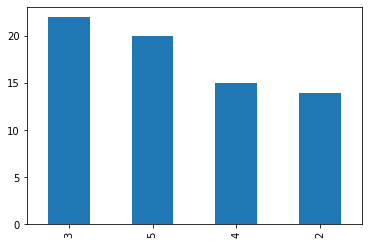

In [19]:
december.value_counts().plot(kind="bar")

From this short analysis I can say that we have certain patterns in posting - most of post are published in the working days, during business time.

# **Posted_time analysis**

Here I'll be analysing posted_time variable, figure out how we can represent correctly it and divide it on buckets.

## Understand posted date in the dataset and its correlations

In [20]:
train_df.posted_time.describe()

count    9.418000e+03
mean     1.543272e+09
std      1.738320e+07
min      1.372140e+09
25%      1.530010e+09
50%      1.545060e+09
75%      1.556120e+09
max      1.573060e+09
Name: posted_time, dtype: float64

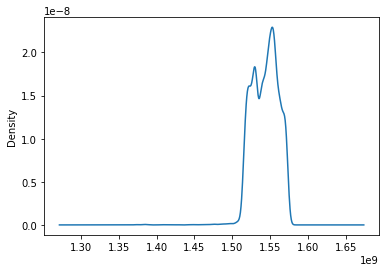

In [21]:
# plot distribution of the values
train_df.posted_time.plot.kde()

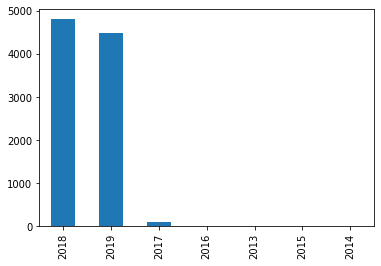

In [22]:
# plot distribution by years
pd.Series([get_date_separated(i)[0] for i in train_df.posted_time]).value_counts().plot(kind="bar")

As we can see, there are few outliers in terms of years, so I'll filter them, to get data only for last 2 years (2018-2019)

In [23]:
# first day of the 2018 year, all previous dates will be removed from the dataset

start_of_2018 = "1/1/2018"
start_secs = time.mktime(datetime.datetime.strptime(start_of_2018, "%d/%m/%Y").timetuple())

get_date(start_secs)

'Monday, 01/01/2018 00:00:00'

In [68]:
filtered_data = [e for e in  filter(lambda x : x > start_secs, train_df.posted_time)]
len(filtered_data)

9280

In [0]:
# remove all dates before 2018 year
new_train_df = train_df[train_df.posted_time.isin(filtered_data)]

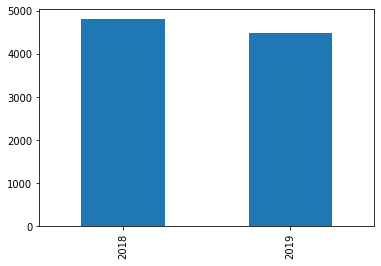

In [26]:
# plot distribution by years
pd.Series([get_date_separated(i)[0] for i in new_train_df.posted_time]).value_counts().plot(kind="bar")

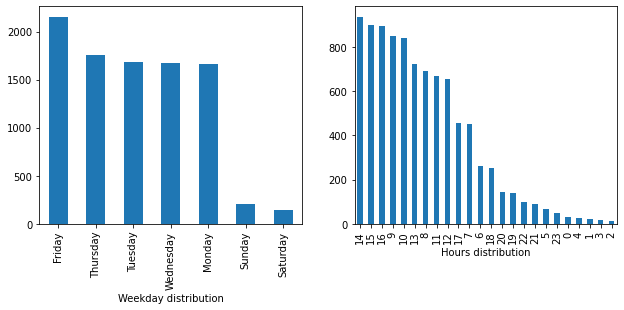

In [27]:
plt.figure(figsize=(16, 4))


plt.subplot(131)
pd.Series([get_date_separated(i)[2] for i in new_train_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Weekday distribution')


plt.subplot(132)
pd.Series([get_date_separated(i)[4] for i in new_train_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution')

plt.show()

So, we have the most of activity in the working days and in the business time (~ 8-18).

Now, let's check most active hours separately for each working day.

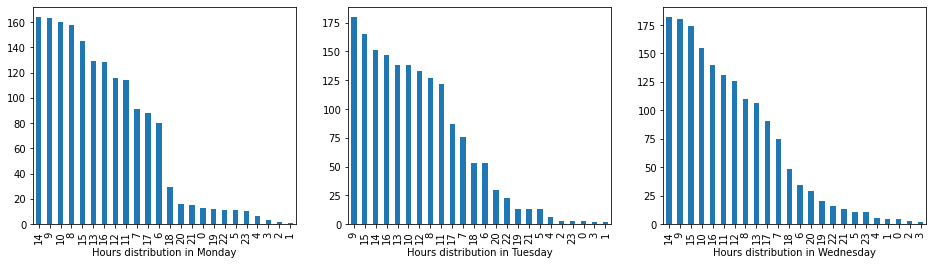

In [28]:
plt.figure(figsize=(16, 4))

plt.subplot(131)
pd.Series([get_date_separated(i)[4] for i in new_train_df.posted_time if get_date_separated(i)[2] == "Monday"]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution in Monday')


plt.subplot(132)
pd.Series([get_date_separated(i)[4] for i in new_train_df.posted_time if get_date_separated(i)[2] == "Tuesday"]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution in Tuesday')


plt.subplot(133)
pd.Series([get_date_separated(i)[4] for i in new_train_df.posted_time if get_date_separated(i)[2] == "Wednesday"]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution in Wednesday')

plt.show()

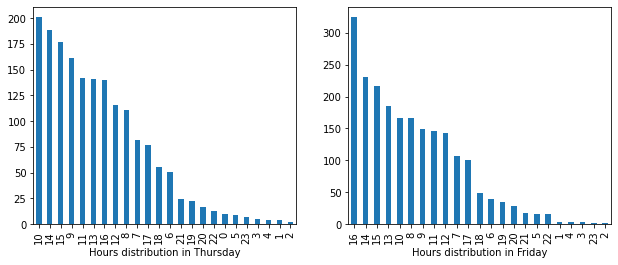

In [29]:
plt.figure(figsize=(16, 4))

plt.subplot(131)
pd.Series([get_date_separated(i)[4] for i in new_train_df.posted_time if get_date_separated(i)[2] == "Thursday"]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution in Thursday')


plt.subplot(132)
pd.Series([get_date_separated(i)[4] for i in new_train_df.posted_time if get_date_separated(i)[2] == "Friday"]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution in Friday')

plt.show()

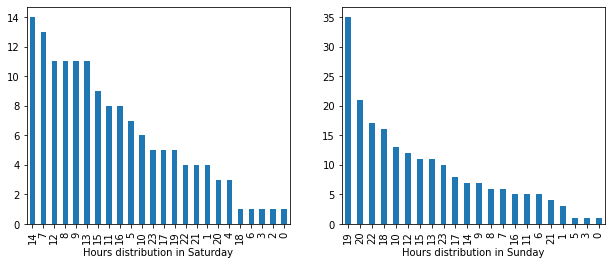

In [30]:
plt.figure(figsize=(16, 4))

plt.subplot(131)
pd.Series([get_date_separated(i)[4] for i in new_train_df.posted_time if get_date_separated(i)[2] == "Saturday"]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution in Saturday')


plt.subplot(132)
pd.Series([get_date_separated(i)[4] for i in new_train_df.posted_time if get_date_separated(i)[2] == "Sunday"]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution in Sunday')

plt.show()

Now, let's check correlations of posted_time and others features. 

In [32]:
# take only one variable to check correlation with
posted_time = new_train_df.posted_time

# check Pearson correlation of posted_time feature
one_feat_corr(new_train_df, posted_time, "pearson")

[('age', -0.9999999836787741),
 ('updated_age', -0.9865471167998696),
 ('participant2_is_in_connections', -0.14459773157001282),
 ('participant4_is_in_connections', -0.11251793770064376),
 ('participant3_is_in_connections', -0.11074623638367513),
 ('participant5_is_in_connections', -0.1090397977689792),
 ('poster_is_in_connections', -0.1071745660821824),
 ('is_mentions_connections', -0.09451543261238941),
 ('owner_influence', -0.09239722410802596),
 ('participant1_is_in_connections', -0.09004742169635047),
 ('is_mentions_me', -0.012379756477246878),
 ('owner_id', 0.01042822972442454),
 ('is_commented_by_me', 0.019159349266718233),
 ('is_liked_by_me', 0.02090809697365507),
 ('is_commented_by_connections', 0.029000188066404874),
 ('number_of_comments', 0.04410320930880777),
 ('poster_influence', 0.06546758250254985),
 ('reactivity', 0.0764413003569501),
 ('poster_is_employee', 0.15513784415169316),
 ('poster_id', 0.15984635485835097),
 ('participant4_influence', 0.18018805106536148),
 ('

In [33]:
one_feat_corr(new_train_df, posted_time, "spearman")

[('age', -0.9999971130121368),
 ('updated_age', -0.9889213331966522),
 ('participant2_is_in_connections', -0.14308043437943813),
 ('participant4_is_in_connections', -0.1119750968145157),
 ('participant3_is_in_connections', -0.11019396241876389),
 ('participant5_is_in_connections', -0.10738340748651397),
 ('poster_is_in_connections', -0.10667151170201489),
 ('is_mentions_connections', -0.09644574715617368),
 ('participant1_is_in_connections', -0.08957581720230083),
 ('owner_influence', -0.0454638752699521),
 ('poster_influence', -0.0390585054489501),
 ('is_mentions_me', -0.012104788631301195),
 ('owner_id', 0.011828198290499746),
 ('is_commented_by_me', 0.018430582770944844),
 ('is_liked_by_me', 0.020133656135645467),
 ('is_commented_by_connections', 0.02964761369396826),
 ('participant1_influence', 0.05463906666279597),
 ('number_of_comments', 0.05720851839617039),
 ('reactivity', 0.08088122362854228),
 ('participant2_influence', 0.10822163278263604),
 ('participant3_id', 0.13507561287

## Equation to describe activity age
Here I'll be creating new synthetic feature - **effective_age**.
As you can see from previous section, each workday has peak of activity (posting activity) , and I assume that reading activity in general will have similar distribution for each workday. For each post effective_age will be a random value from certain interval which depends on how close to peak post_time is. For peak post this interval will be [10min, 2h] and [30min-4h] for others. If posted_time + random value will be outside business time (8 AM - 19 PM) random value will be doubled.

Peak times for each workday:

**Mon**: 8, 9, 10 AM

**Tue**: 13, 14, 15 PM

**Wed**: 14, 15, 16 PM

**Thu**: 9, 10, 11 AM

**Fri**: 14, 15, 16 PM


\

\




\* *Intervals of random values are tunned below* 

In [0]:
# one minute = 60 secs
one_min = 60
one_hour = 60 * one_min

# define random values intervals
peak_interval_short = (10 * one_min, one_hour)            # [10min, 1h]
nonpeak_interval_short = (30 * one_min, 2 * one_hour)     # [30min, 2h]

peak_interval_middle = (10 * one_min, 2 * one_hour)       # [10min, 2h]
nonpeak_interval_middle = (30 * one_min, 4 * one_hour)    # [30min, 4h]

peak_interval_long = (10 * one_min, 4 * one_hour)         # [10min, 4h]
nonpeak_interval_long = (30 * one_min, 8 * one_hour)      # [30min, 8h]


# define start of peak time for each day
day2peak = {
    "Monday" : 8,
    "Tuesday" : 13,
    "Wednesday" : 14,
    "Thursday" : 9,
    "Friday" : 14
}

In [0]:
# func for check whether  time is peak or not
def is_peak(secs):
  date = get_date_separated(secs)
  weekday = date[2]

  # take start of the peak time from the date in seconds
  start = day2peak[weekday] * one_hour
  # define end as 3 hours after start
  end = start + 3 * one_hour
  
  # define current time in terms of seconds - seconds in hours + seconds in minutes and seconds
  current_secs = (one_hour * date[4]) + (one_min * date[5]) + date[6]

  return start <= current_secs  <= end

In [0]:
# func for check whether time is in business time 
def in_working_time(secs):
  date = get_date_separated(secs)

  # define start and end of the working day, i.e 8 AM and 18 PM
  business_time_start = 8 * one_hour
  business_time_end = 19 * one_hour

  # define current time in terms of seconds - seconds in hours + seconds in minutes and seconds
  current_secs = (one_hour * date[4]) + (one_min * date[5]) + date[6]

  return business_time_start < current_secs < business_time_end


In [0]:
# func for check whether time is weekend 
def is_weekend(secs):
  date = get_date_separated(secs)

  weekday = date[2]
  if weekday == 'Saturday' or weekday == 'Sunday':
    return True

In [0]:
import random

def create_effective_age(posted_time, peak, nonpeak):
  effective_ages = []


  for t in posted_time:

    # if is weekend, take wider(for non peak) interval and double it
    if is_weekend(t):
      effective_age = random.randint(nonpeak[0], nonpeak[1]) * 2
      effective_ages.append(effective_age)
      continue

    # asign random value from corresponding interval
    if is_peak(t):
      effective_age = random.randint(peak[0], peak[1])
    else:
      effective_age = random.randint(nonpeak[0], nonpeak[1])

    # if is outside bussines time - double
    if not in_working_time(t + effective_age):
      effective_age *= 2
  

    effective_ages.append(effective_age)

  return effective_ages

Here I'll add 3 new synthetic features effective_age with different interval of random values.

In [0]:
new_train_df["effective_age_short"] = create_effective_age(new_train_df.posted_time, peak_interval_short, nonpeak_interval_short)
new_train_df["effective_age_middle"] = create_effective_age(new_train_df.posted_time, peak_interval_middle, nonpeak_interval_middle)
new_train_df["effective_age_long"] = create_effective_age(new_train_df.posted_time, peak_interval_long, nonpeak_interval_long)

In [40]:
new_train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_gender,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_focus,poster_order,poster_influence,participant1_id,participant1_action,participant1_gender,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_focus,participant1_order,participant1_influence,participant2_id,participant2_action,participant2_gender,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_focus,participant2_order,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_focus,participant3_order,participant3_influence,participant4_id,participant4_action,participant4_gender,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_focus,participant4_order,participant4_influence,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank,effective_age_short,effective_age_middle,effective_age_long
51,175684,1.514880e+09,1.515140e+09,6.232333e+07,6.206286e+07,other,3201,space,0.99992,30,6,0.310842,0,1,0,1,0,1,5,male,1,0,1,marketing,6,0.99962,38,commented,female,1,0,1,marketing,5,0.99825,13,commented,male,1,0,1,marketing,4,0.99895,110965,commented,male,0,0,1,marketing,3,0.99861,10,commented,male,1,0,1,marketing,2,0.99902,7,commented,male,1,0,1,marketing,1,0.99886,0.87644,3509,7273,27665
52,175698,1.514890e+09,1.514890e+09,6.231682e+07,6.231682e+07,other,9037,space,0.99949,0,0,0.000000,0,0,0,0,0,0,1,male,1,0,1,sales,6,0.99645,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61486,6095,11132,25673
53,175714,1.514900e+09,1.514910e+09,6.230383e+07,6.230069e+07,other,13853,space,0.10000,1,2,0.000000,0,1,0,1,0,1,78,female,1,0,1,marketing,6,0.99808,121,commented,male,1,0,1,marketing,5,0.99919,62,commented,male,1,0,1,marketing,4,0.99586,37,commented,female,1,0,1,marketing,3,0.99339,5,commented,male,1,0,1,marketing,2,0.99962,22636,viewed,male,0,0,1,other,1,0.23077,0.85888,2009,6468,7368
54,175728,1.514910e+09,1.519330e+09,6.229707e+07,5.787155e+07,forum,111913,space,0.99977,1,3,0.000000,0,0,0,1,0,1,5,male,1,0,1,marketing,6,0.99962,13659,commented,male,0,0,0,other,5,0.99756,16,commented,male,0,0,1,other,4,0.99630,5,commented,male,1,0,1,marketing,3,0.99962,121,liked,male,1,0,1,marketing,2,0.99919,22636,viewed,male,0,0,1,other,1,0.23077,0.85278,3258,26218,54080
55,175779,1.514980e+09,1.515490e+09,6.222975e+07,6.171553e+07,other,27310,space,0.99980,1,5,0.229476,0,1,0,1,0,1,121,male,1,0,1,marketing,6,0.99919,1,commented,male,1,0,1,sales,5,0.99645,121,commented,male,1,0,1,marketing,4,0.99919,67,commented,female,0,0,1,marketing,3,0.99806,108025,commented,male,1,0,0,marketing,2,0.99891,151,commented,male,1,0,1,marketing,1,0.99811,0.87639,7192,9727,18824


# **Effective_age**
Here I'll proceed with new synthetic feature named effective_age

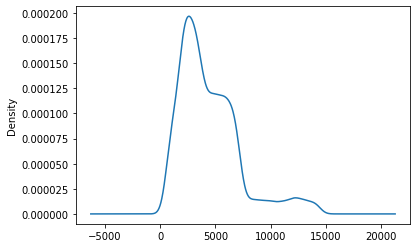

In [41]:
new_train_df.effective_age_short.plot.kde()

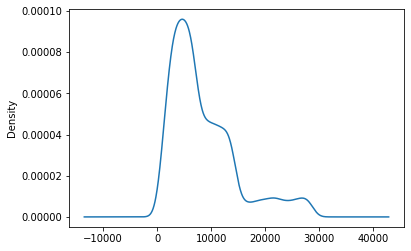

In [42]:
new_train_df.effective_age_middle.plot.kde()

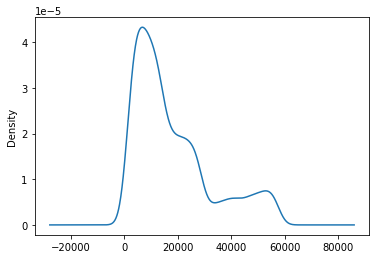

In [43]:
new_train_df.effective_age_long.plot.kde()

Next, I`ll compare correlations of these features to whole dataset to choose best interval (short, middle or long).

In [0]:
def create_corr_df(df, features, corr_method):
  
  # take first feature of dataframe to compute correlations
  first_feature = df[features[0]]
  
  # compute correlations of this feature
  first_corr = df.corrwith(first_feature, method=corr_method)
  
  # take list of features, with which correlation will be computed
  cols = first_corr.index

  # create dataframe of correlations, where each row is features[i], and each column corresponds to feature of target dataframe
  corrs_df = pd.DataFrame([list(first_corr)], columns=cols)

  # do same for rest of features
  for i in range(1, len(features)):
    feature = df[features[i]]
    corr = list(df.corrwith(feature, method=corr_method))
    corrs_df = corrs_df.append(pd.DataFrame([corr], columns=cols), ignore_index=True)

  return corrs_df


In [0]:
pearson_corr_df = create_corr_df(new_train_df, ["effective_age_short",
                                                "effective_age_middle",
                                                "effective_age_long"], "pearson")

In [47]:
pearson_corr_df

,id,posted_time,updated_time,age,updated_age,owner_id,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_order,poster_influence,participant1_id,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_order,participant1_influence,participant2_id,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_order,participant2_influence,participant3_id,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_order,participant3_influence,participant4_id,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_order,participant4_influence,participant5_id,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_order,participant5_influence,rank,effective_age_short,effective_age_middle,effective_age_long
0,-0.037902,-0.036920,-0.036375,0.036920,0.036372,0.064392,0.002735,-0.013115,-0.028413,-0.007372,0.012605,-0.009143,0.012147,-0.030883,0.034732,0.025873,-0.005529,0.008805,NaN,-0.035798,NaN,0.039154,-0.027679,0.033243,NaN,0.001815,NaN,0.016284,-0.020021,0.007341,NaN,0.003687,NaN,-0.001979,-0.045939,-0.000475,NaN,0.031091,NaN,-0.005915,-0.029533,-0.005579,NaN,0.014384,NaN,-0.012356,-0.029948,-0.032163,NaN,0.021450,NaN,-0.030193,0.015733,1.000000,0.450432,0.342819
1,-0.039871,-0.039739,-0.038398,0.039747,0.038403,0.038490,0.005508,0.001112,-0.009016,0.010757,0.024284,-0.007733,0.020721,0.004073,0.039273,0.015078,-0.003934,0.008880,NaN,-0.030720,NaN,0.030182,-0.037416,0.034861,NaN,0.011408,NaN,0.016411,-0.028511,0.008002,NaN,-0.005033,NaN,0.006481,-0.038290,0.008536,NaN,0.028625,NaN,-0.000003,-0.041012,-0.006537,NaN,0.010781,NaN,-0.001527,-0.020103,-0.021493,NaN,0.012806,NaN,-0.018476,0.024498,0.450432,1.000000,0.342228
2,-0.007509,-0.008400,-0.008959,0.008405,0.008960,0.021937,0.002703,-0.011195,-0.020169,0.019332,0.009515,-0.007016,-0.004543,-0.008048,0.020991,0.017889,-0.008112,0.009504,NaN,-0.020152,NaN,0.021342,-0.026859,0.028827,NaN,0.010182,NaN,0.023552,-0.005765,0.010038,NaN,0.001233,NaN,0.002775,-0.025531,0.005271,NaN,0.021371,NaN,-0.005148,-0.021234,-0.008244,NaN,0.014737,NaN,-0.009901,-0.020135,-0.019285,NaN,0.009787,NaN,-0.022006,0.013164,0.342819,0.342228,1.000000


In [0]:
spearman_corr_df = create_corr_df(new_train_df, ["effective_age_short",
                                                 "effective_age_middle",
                                                 "effective_age_long"], "spearman")

In [49]:
spearman_corr_df

,id,posted_time,updated_time,age,updated_age,owner_id,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_order,poster_influence,participant1_id,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_order,participant1_influence,participant2_id,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_order,participant2_influence,participant3_id,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_order,participant3_influence,participant4_id,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_order,participant4_influence,participant5_id,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_order,participant5_influence,rank,effective_age_short,effective_age_middle,effective_age_long
0,-0.021552,-0.021569,-0.019800,0.021552,0.019783,0.074768,0.004671,0.003524,-0.021894,0.006002,0.010032,-0.009537,0.003027,-0.023488,0.031996,0.021493,-0.012847,0.007837,NaN,-0.038372,NaN,0.061128,-0.023928,0.02192,NaN,-0.007589,NaN,0.046774,-0.023296,0.011802,NaN,0.004527,NaN,0.018843,-0.040084,-0.000650,NaN,0.021730,NaN,0.009591,-0.024255,-0.006890,NaN,0.016664,NaN,0.002199,-0.009554,-0.029743,NaN,0.021504,NaN,-0.019700,-0.008178,1.000000,0.463069,0.365765
1,-0.034649,-0.034668,-0.033013,0.034649,0.032992,0.050890,0.016924,0.003251,0.002754,0.015553,0.019729,-0.007379,0.015557,0.008421,0.038585,0.018118,-0.009019,0.007893,NaN,-0.029083,NaN,0.042483,-0.048359,0.03027,NaN,0.006061,NaN,0.057191,-0.033438,0.007900,NaN,-0.012689,NaN,0.025805,-0.038674,0.002695,NaN,0.028828,NaN,0.012799,-0.040531,-0.003395,NaN,0.005004,NaN,0.010649,0.001785,-0.024491,NaN,0.015973,NaN,-0.012617,0.005104,0.463069,1.000000,0.329291
2,-0.011928,-0.011944,-0.011539,0.011928,0.011521,0.035071,0.004870,-0.008876,-0.012802,0.028235,0.011782,-0.015176,-0.003413,-0.013928,0.020983,0.014743,-0.008339,0.006498,NaN,-0.016186,NaN,0.031644,-0.034674,0.02708,NaN,0.008707,NaN,0.044357,-0.013283,0.007430,NaN,0.004765,NaN,0.006098,-0.023843,-0.002788,NaN,0.021048,NaN,-0.001157,-0.015646,-0.012666,NaN,0.026098,NaN,-0.013360,-0.003391,-0.030085,NaN,0.017256,NaN,-0.026652,-0.013265,0.365765,0.329291,1.000000


In [50]:
new_train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_gender,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_focus,poster_order,poster_influence,participant1_id,participant1_action,participant1_gender,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_focus,participant1_order,participant1_influence,participant2_id,participant2_action,participant2_gender,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_focus,participant2_order,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_focus,participant3_order,participant3_influence,participant4_id,participant4_action,participant4_gender,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_focus,participant4_order,participant4_influence,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank,effective_age_short,effective_age_middle,effective_age_long
51,175684,1.514880e+09,1.515140e+09,6.232333e+07,6.206286e+07,other,3201,space,0.99992,30,6,0.310842,0,1,0,1,0,1,5,male,1,0,1,marketing,6,0.99962,38,commented,female,1,0,1,marketing,5,0.99825,13,commented,male,1,0,1,marketing,4,0.99895,110965,commented,male,0,0,1,marketing,3,0.99861,10,commented,male,1,0,1,marketing,2,0.99902,7,commented,male,1,0,1,marketing,1,0.99886,0.87644,3509,7273,27665
52,175698,1.514890e+09,1.514890e+09,6.231682e+07,6.231682e+07,other,9037,space,0.99949,0,0,0.000000,0,0,0,0,0,0,1,male,1,0,1,sales,6,0.99645,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61486,6095,11132,25673
53,175714,1.514900e+09,1.514910e+09,6.230383e+07,6.230069e+07,other,13853,space,0.10000,1,2,0.000000,0,1,0,1,0,1,78,female,1,0,1,marketing,6,0.99808,121,commented,male,1,0,1,marketing,5,0.99919,62,commented,male,1,0,1,marketing,4,0.99586,37,commented,female,1,0,1,marketing,3,0.99339,5,commented,male,1,0,1,marketing,2,0.99962,22636,viewed,male,0,0,1,other,1,0.23077,0.85888,2009,6468,7368
54,175728,1.514910e+09,1.519330e+09,6.229707e+07,5.787155e+07,forum,111913,space,0.99977,1,3,0.000000,0,0,0,1,0,1,5,male,1,0,1,marketing,6,0.99962,13659,commented,male,0,0,0,other,5,0.99756,16,commented,male,0,0,1,other,4,0.99630,5,commented,male,1,0,1,marketing,3,0.99962,121,liked,male,1,0,1,marketing,2,0.99919,22636,viewed,male,0,0,1,other,1,0.23077,0.85278,3258,26218,54080
55,175779,1.514980e+09,1.515490e+09,6.222975e+07,6.171553e+07,other,27310,space,0.99980,1,5,0.229476,0,1,0,1,0,1,121,male,1,0,1,marketing,6,0.99919,1,commented,male,1,0,1,sales,5,0.99645,121,commented,male,1,0,1,marketing,4,0.99919,67,commented,female,0,0,1,marketing,3,0.99806,108025,commented,male,1,0,0,marketing,2,0.99891,151,commented,male,1,0,1,marketing,1,0.99811,0.87639,7192,9727,18824


In [0]:
# drop redundant columns to make more readable correlation matrix

# drop ids columns
tmp_df = new_train_df.drop(["id", "owner_id", "poster_id", "participant1_id",
                            "participant2_id", "participant3_id",
                            "participant4_id", "participant5_id"], axis=1)

# drop columns which produce no correlation, as their values are static over all data set
tmp_df = tmp_df.drop(["poster_is_lead", "poster_order",
                      "participant1_is_lead", "participant1_order",
                      "participant2_is_lead", "participant2_order",
                      "participant3_is_lead", "participant3_order",
                      "participant4_is_lead", "participant4_order",
                      "participant5_is_lead", "participant5_order",], axis=1)

In [0]:
def plot_corr_matrix(df, corr_method):
  plt.figure(figsize = (36,22))
  plt.title('Correlation Heatmap', fontsize = 16);

  # Mask to remove redundancy from the heatmap.
  mask = np.zeros_like(df.corr(method=corr_method), dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(df.corr(method=corr_method), mask=mask, vmin=-1, vmax = 1, cmap = "coolwarm",  annot = True)

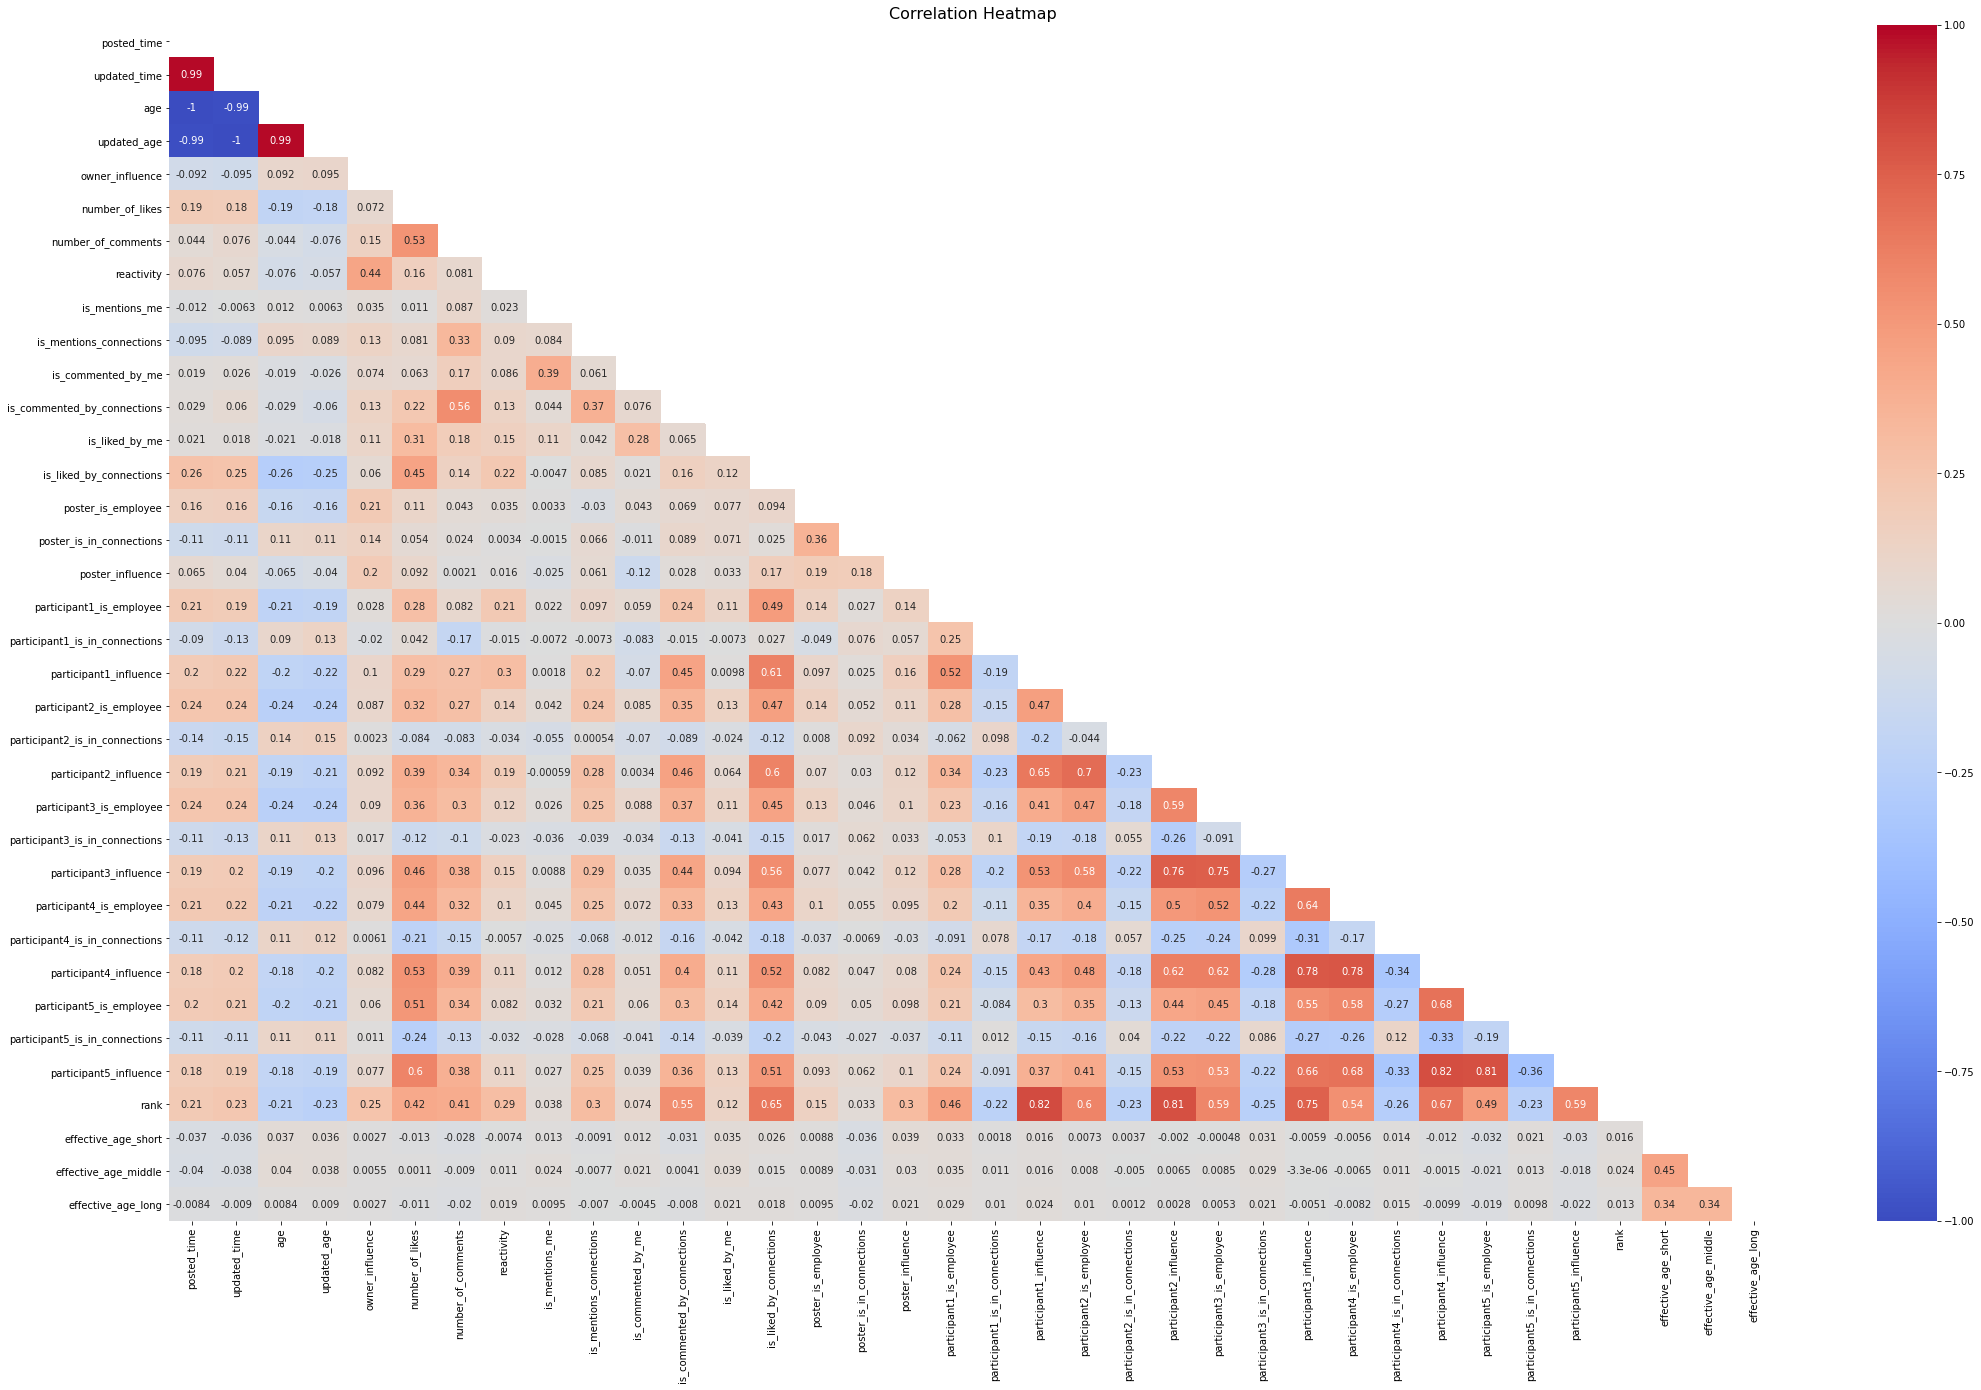

In [61]:
plot_corr_matrix(tmp_df, "pearson")

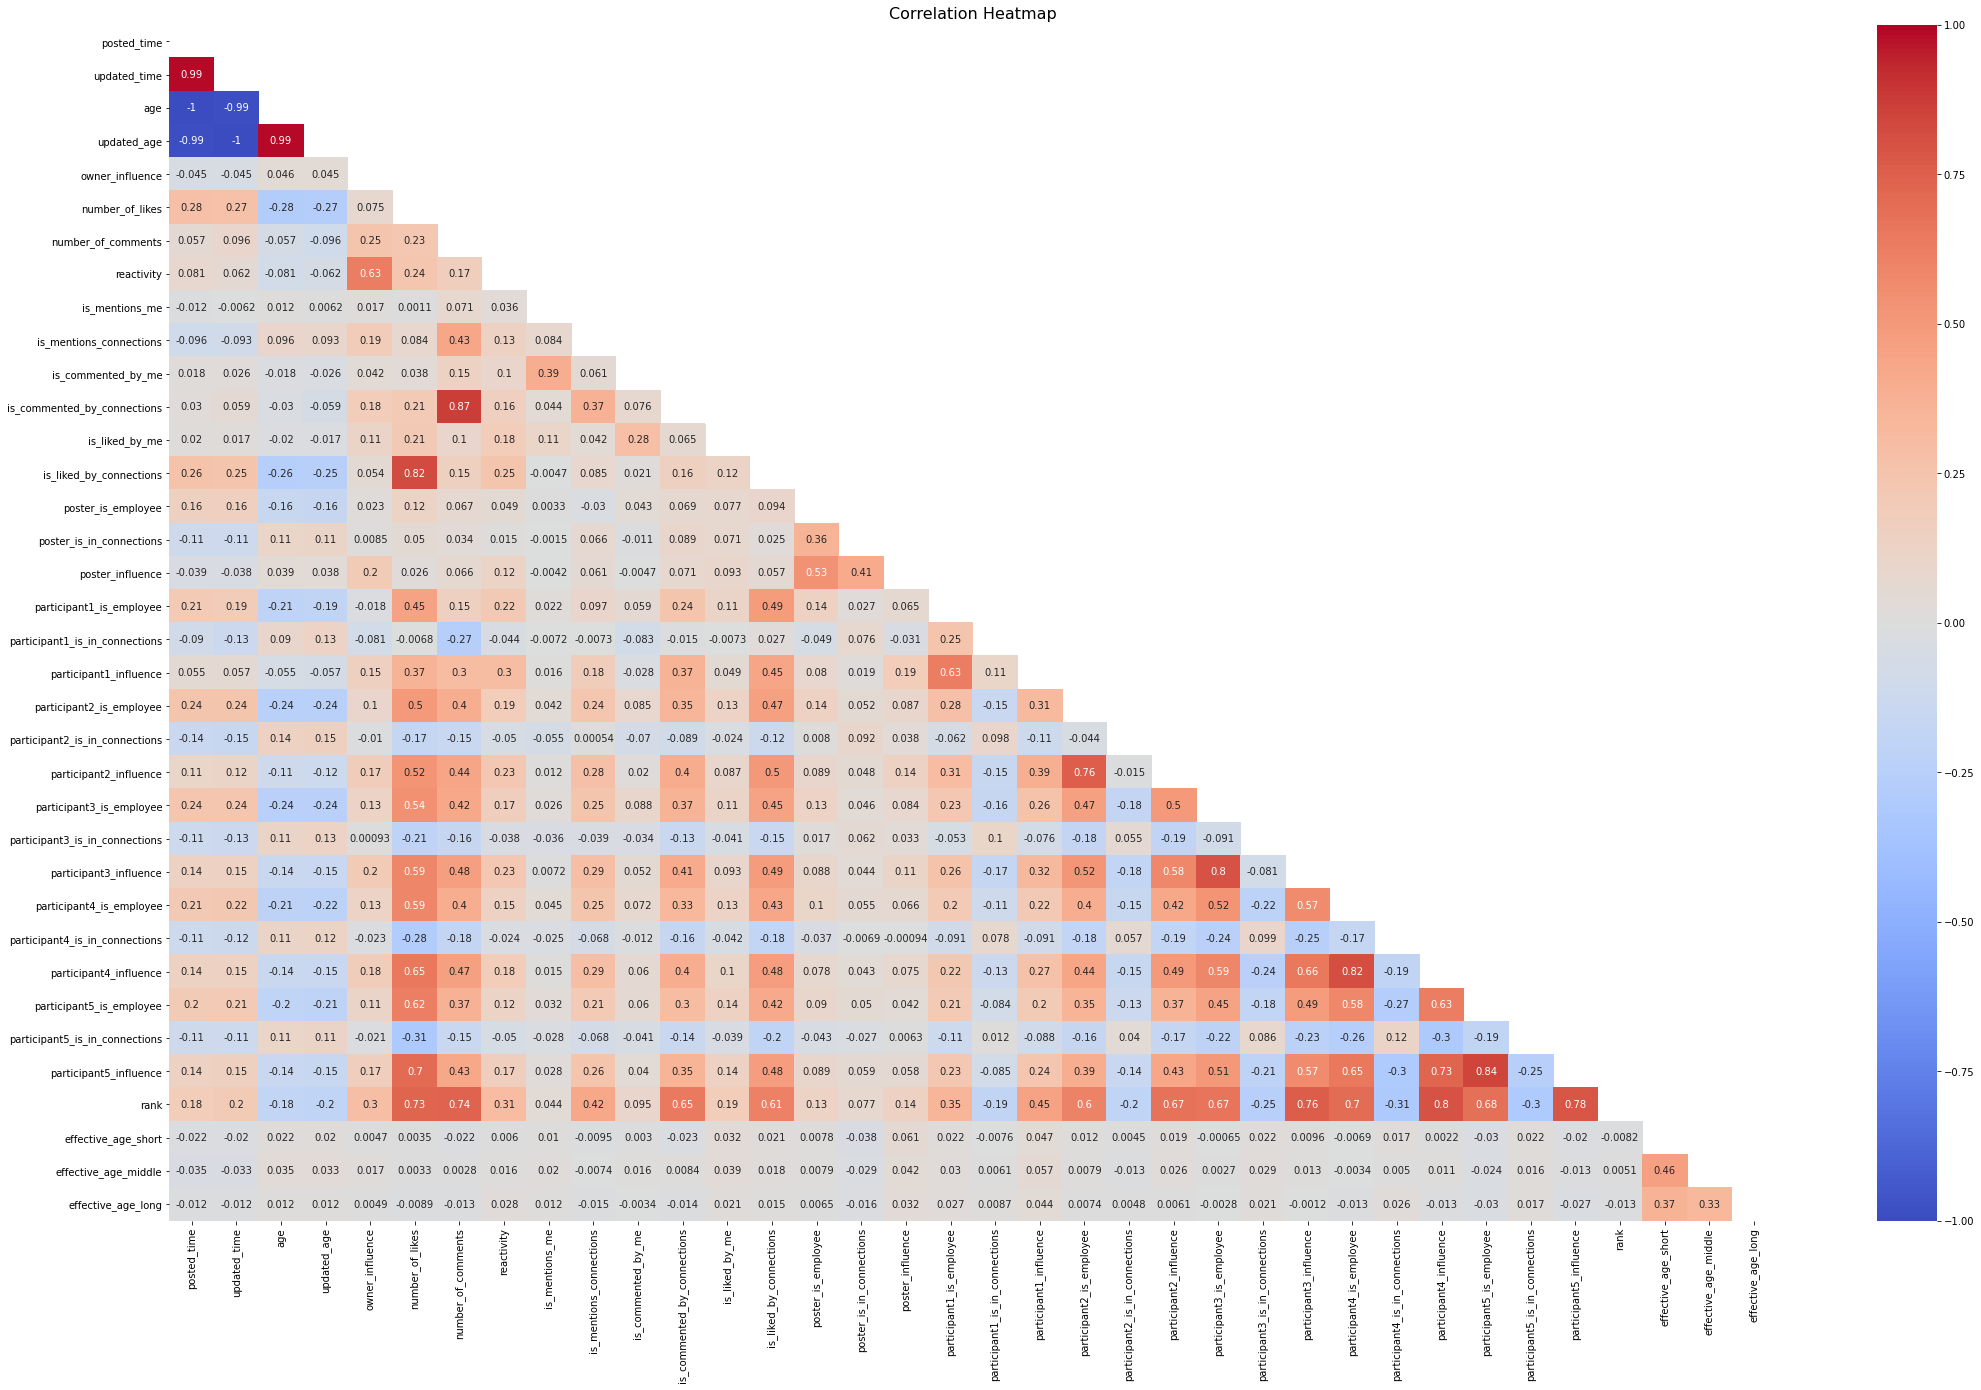

In [62]:
plot_corr_matrix(tmp_df, "spearman")

After testing each of these 3 synthetic features, I've got such results:


> Short interval ( Peak: [10min, 1h], Nonpeak: [30min, 2h] )

*   Average accuracy: 0.010842246500154336
*   Average time for training: 141.20282495816548

> Middle interval ( Peak: [10min, 2h], Nonpeak: [30min, 4h] )

*   Average accuracy: 0.01106303851478375
*   Average time for training: 143.3265394369761

> Long interval ( Peak: [10min, 4h], Nonpeak: [30min, 8h] )

*   Average accuracy: 0.009986062567414982
*   Average time for training: 142.25385648409525



As long interval shows better accuracy and correlations, it was decided to use it.















In [72]:
new_train_df.drop(["effective_age_short", "effective_age_middle"], axis=1, inplace=True)
new_train_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_gender,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_focus,poster_order,poster_influence,participant1_id,participant1_action,participant1_gender,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_focus,participant1_order,participant1_influence,participant2_id,participant2_action,participant2_gender,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_focus,participant2_order,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_focus,participant3_order,participant3_influence,participant4_id,participant4_action,participant4_gender,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_focus,participant4_order,participant4_influence,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank,effective_age_long
51,175684,1.514880e+09,1.515140e+09,6.232333e+07,6.206286e+07,other,3201,space,0.99992,30,6,0.310842,0,1,0,1,0,1,5,male,1,0,1,marketing,6,0.99962,38,commented,female,1,0,1,marketing,5,0.99825,13,commented,male,1,0,1,marketing,4,0.99895,110965,commented,male,0,0,1,marketing,3,0.99861,10,commented,male,1,0,1,marketing,2,0.99902,7,commented,male,1,0,1,marketing,1,0.99886,0.87644,16948
52,175698,1.514890e+09,1.514890e+09,6.231682e+07,6.231682e+07,other,9037,space,0.99949,0,0,0.000000,0,0,0,0,0,0,1,male,1,0,1,sales,6,0.99645,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61486,4926
53,175714,1.514900e+09,1.514910e+09,6.230383e+07,6.230069e+07,other,13853,space,0.10000,1,2,0.000000,0,1,0,1,0,1,78,female,1,0,1,marketing,6,0.99808,121,commented,male,1,0,1,marketing,5,0.99919,62,commented,male,1,0,1,marketing,4,0.99586,37,commented,female,1,0,1,marketing,3,0.99339,5,commented,male,1,0,1,marketing,2,0.99962,22636,viewed,male,0,0,1,other,1,0.23077,0.85888,5100
54,175728,1.514910e+09,1.519330e+09,6.229707e+07,5.787155e+07,forum,111913,space,0.99977,1,3,0.000000,0,0,0,1,0,1,5,male,1,0,1,marketing,6,0.99962,13659,commented,male,0,0,0,other,5,0.99756,16,commented,male,0,0,1,other,4,0.99630,5,commented,male,1,0,1,marketing,3,0.99962,121,liked,male,1,0,1,marketing,2,0.99919,22636,viewed,male,0,0,1,other,1,0.23077,0.85278,5893
55,175779,1.514980e+09,1.515490e+09,6.222975e+07,6.171553e+07,other,27310,space,0.99980,1,5,0.229476,0,1,0,1,0,1,121,male,1,0,1,marketing,6,0.99919,1,commented,male,1,0,1,sales,5,0.99645,121,commented,male,1,0,1,marketing,4,0.99919,67,commented,female,0,0,1,marketing,3,0.99806,108025,commented,male,1,0,0,marketing,2,0.99891,151,commented,male,1,0,1,marketing,1,0.99811,0.87639,20943


# **Additional time features**

Here I'll crete two new features - weekday of publication and time of a day. Features will be bucketized: weekday on 7 days, time of a day on 4 parts: 0-8 AM, 8-12 AM, 12-16 PM, 16-0 PM.


\

\


\* buckets can be changed in a future 

## Weekday feature

In [0]:
def create_weekday(posted_time):

  weekdays = []

  for t in posted_time:
    weekdays.append(get_date_separated(t)[2])

  return weekdays

In [0]:
posted_time = new_train_df.posted_time

new_train_df["weekday"] =  create_weekday(posted_time)

## Time of the day

In [0]:
def create_daytime(posted_time):

  daytimes = []

  for t in posted_time:
    daytimes.append(get_date_separated(t)[4])

  return daytimes

In [0]:
new_train_df["daytime"] =  create_daytime(posted_time)

In [75]:
new_train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_gender,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_focus,poster_order,poster_influence,participant1_id,participant1_action,participant1_gender,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_focus,participant1_order,participant1_influence,participant2_id,participant2_action,participant2_gender,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_focus,participant2_order,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_focus,participant3_order,participant3_influence,participant4_id,participant4_action,participant4_gender,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_focus,participant4_order,participant4_influence,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank,effective_age_long,weekday,daytime
51,175684,1.514880e+09,1.515140e+09,6.232333e+07,6.206286e+07,other,3201,space,0.99992,30,6,0.310842,0,1,0,1,0,1,5,male,1,0,1,marketing,6,0.99962,38,commented,female,1,0,1,marketing,5,0.99825,13,commented,male,1,0,1,marketing,4,0.99895,110965,commented,male,0,0,1,marketing,3,0.99861,10,commented,male,1,0,1,marketing,2,0.99902,7,commented,male,1,0,1,marketing,1,0.99886,0.87644,16948,Tuesday,8
52,175698,1.514890e+09,1.514890e+09,6.231682e+07,6.231682e+07,other,9037,space,0.99949,0,0,0.000000,0,0,0,0,0,0,1,male,1,0,1,sales,6,0.99645,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61486,4926,Tuesday,10
53,175714,1.514900e+09,1.514910e+09,6.230383e+07,6.230069e+07,other,13853,space,0.10000,1,2,0.000000,0,1,0,1,0,1,78,female,1,0,1,marketing,6,0.99808,121,commented,male,1,0,1,marketing,5,0.99919,62,commented,male,1,0,1,marketing,4,0.99586,37,commented,female,1,0,1,marketing,3,0.99339,5,commented,male,1,0,1,marketing,2,0.99962,22636,viewed,male,0,0,1,other,1,0.23077,0.85888,5100,Tuesday,13
54,175728,1.514910e+09,1.519330e+09,6.229707e+07,5.787155e+07,forum,111913,space,0.99977,1,3,0.000000,0,0,0,1,0,1,5,male,1,0,1,marketing,6,0.99962,13659,commented,male,0,0,0,other,5,0.99756,16,commented,male,0,0,1,other,4,0.99630,5,commented,male,1,0,1,marketing,3,0.99962,121,liked,male,1,0,1,marketing,2,0.99919,22636,viewed,male,0,0,1,other,1,0.23077,0.85278,5893,Tuesday,16
55,175779,1.514980e+09,1.515490e+09,6.222975e+07,6.171553e+07,other,27310,space,0.99980,1,5,0.229476,0,1,0,1,0,1,121,male,1,0,1,marketing,6,0.99919,1,commented,male,1,0,1,sales,5,0.99645,121,commented,male,1,0,1,marketing,4,0.99919,67,commented,female,0,0,1,marketing,3,0.99806,108025,commented,male,1,0,0,marketing,2,0.99891,151,commented,male,1,0,1,marketing,1,0.99811,0.87639,20943,Wednesday,11


In [0]:
# drop redundant columns to make more readable correlation matrix

# drop ids columns
tmp_df = new_train_df.drop(["id", "owner_id", "poster_id", "participant1_id",
                            "participant2_id", "participant3_id",
                            "participant4_id", "participant5_id"], axis=1)

# drop columns which produce no correlation, as their values are static over all data set
tmp_df = tmp_df.drop(["poster_is_lead", "poster_order",
                      "participant1_is_lead", "participant1_order",
                      "participant2_is_lead", "participant2_order",
                      "participant3_is_lead", "participant3_order",
                      "participant4_is_lead", "participant4_order",
                      "participant5_is_lead", "participant5_order",], axis=1)

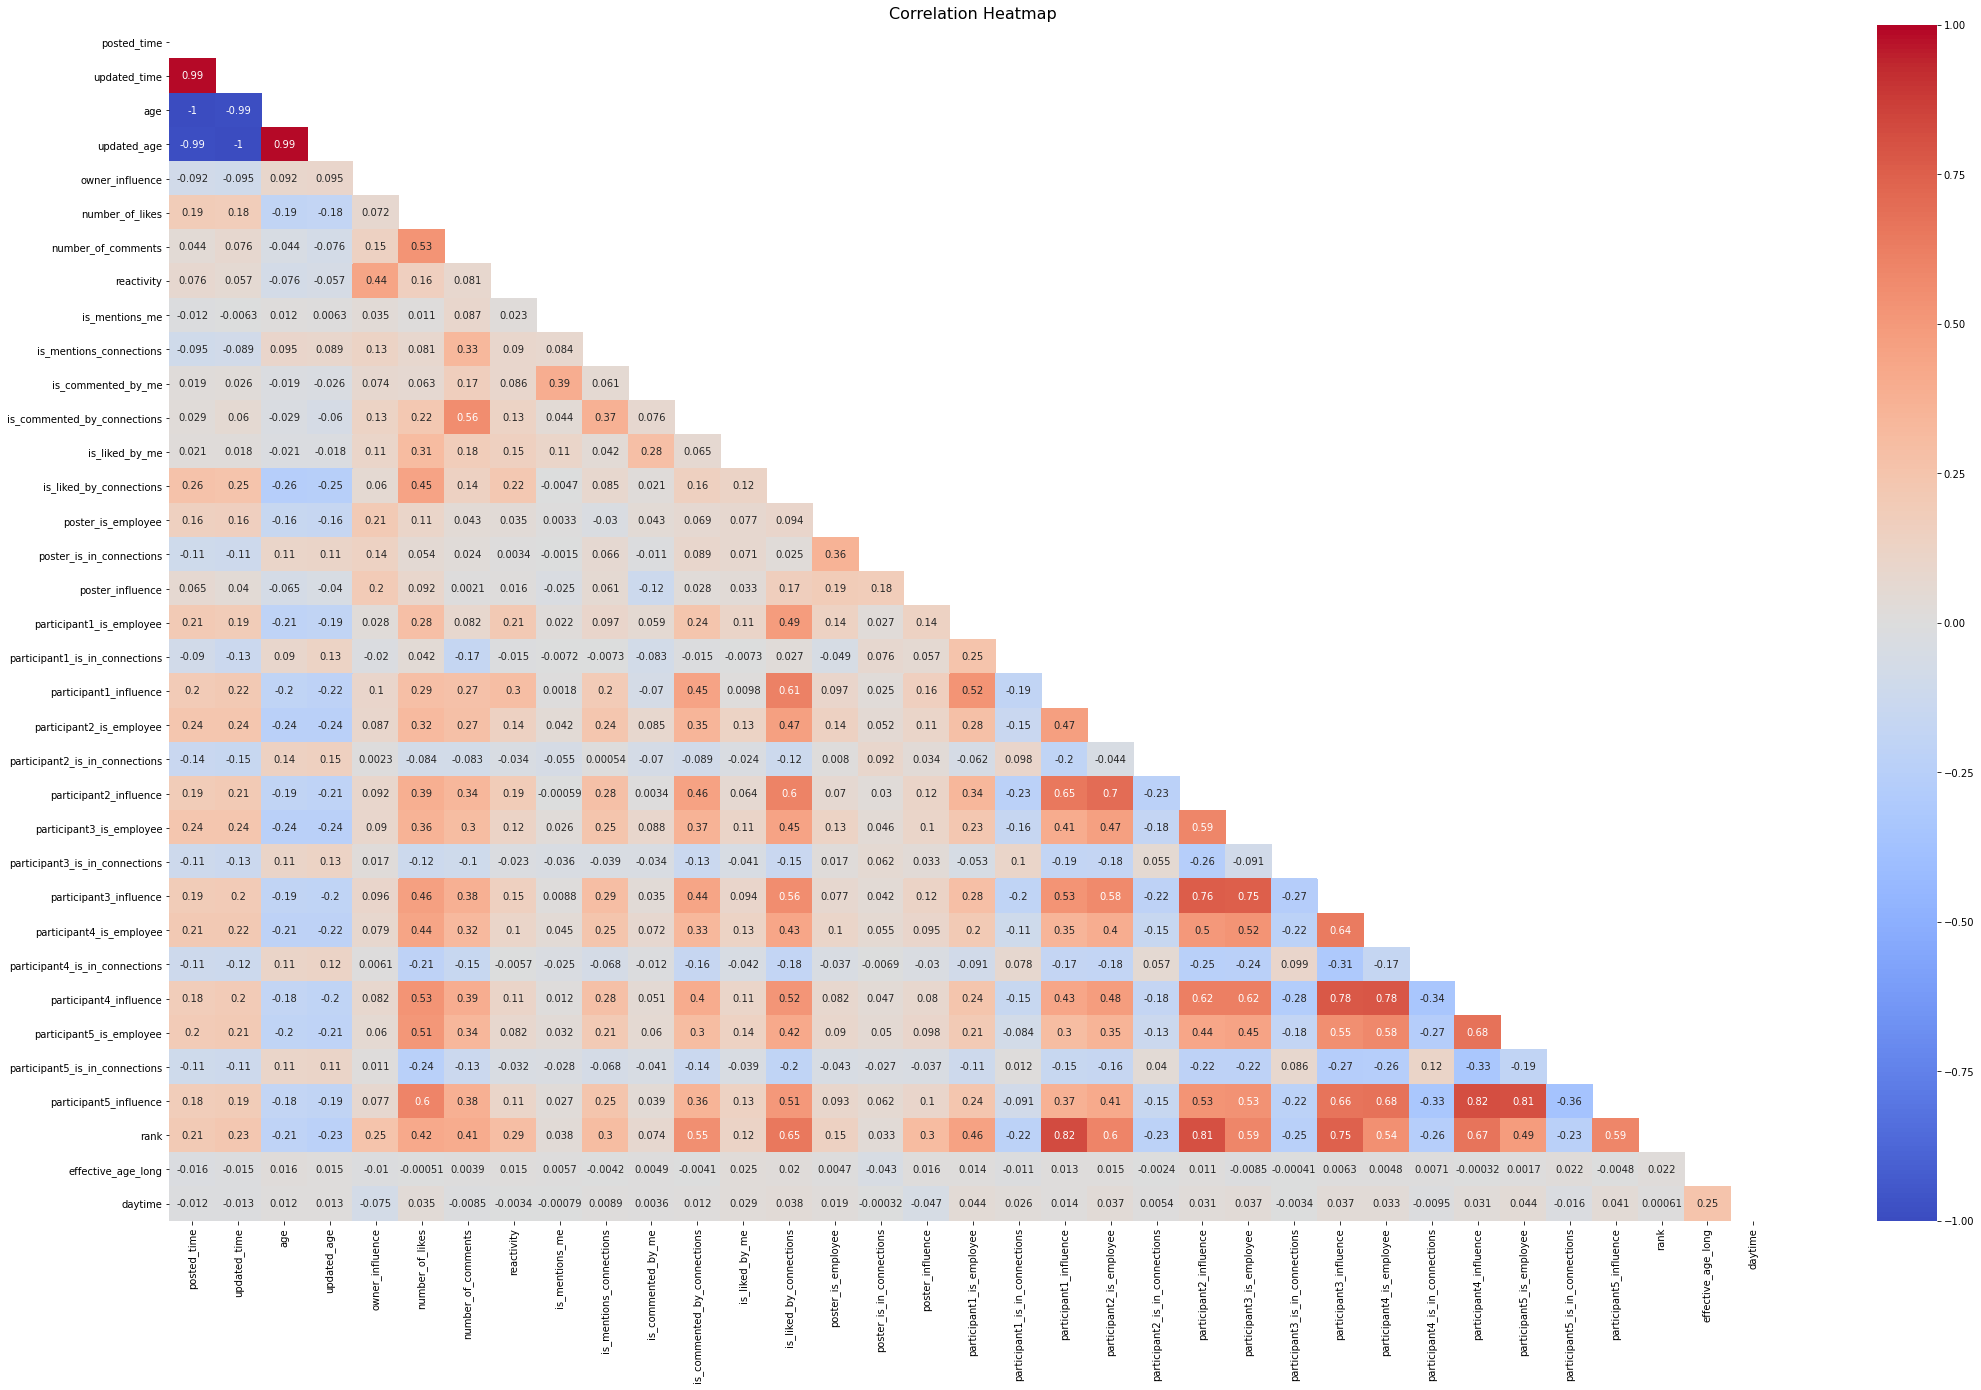

In [77]:
plot_corr_matrix(tmp_df, "pearson")

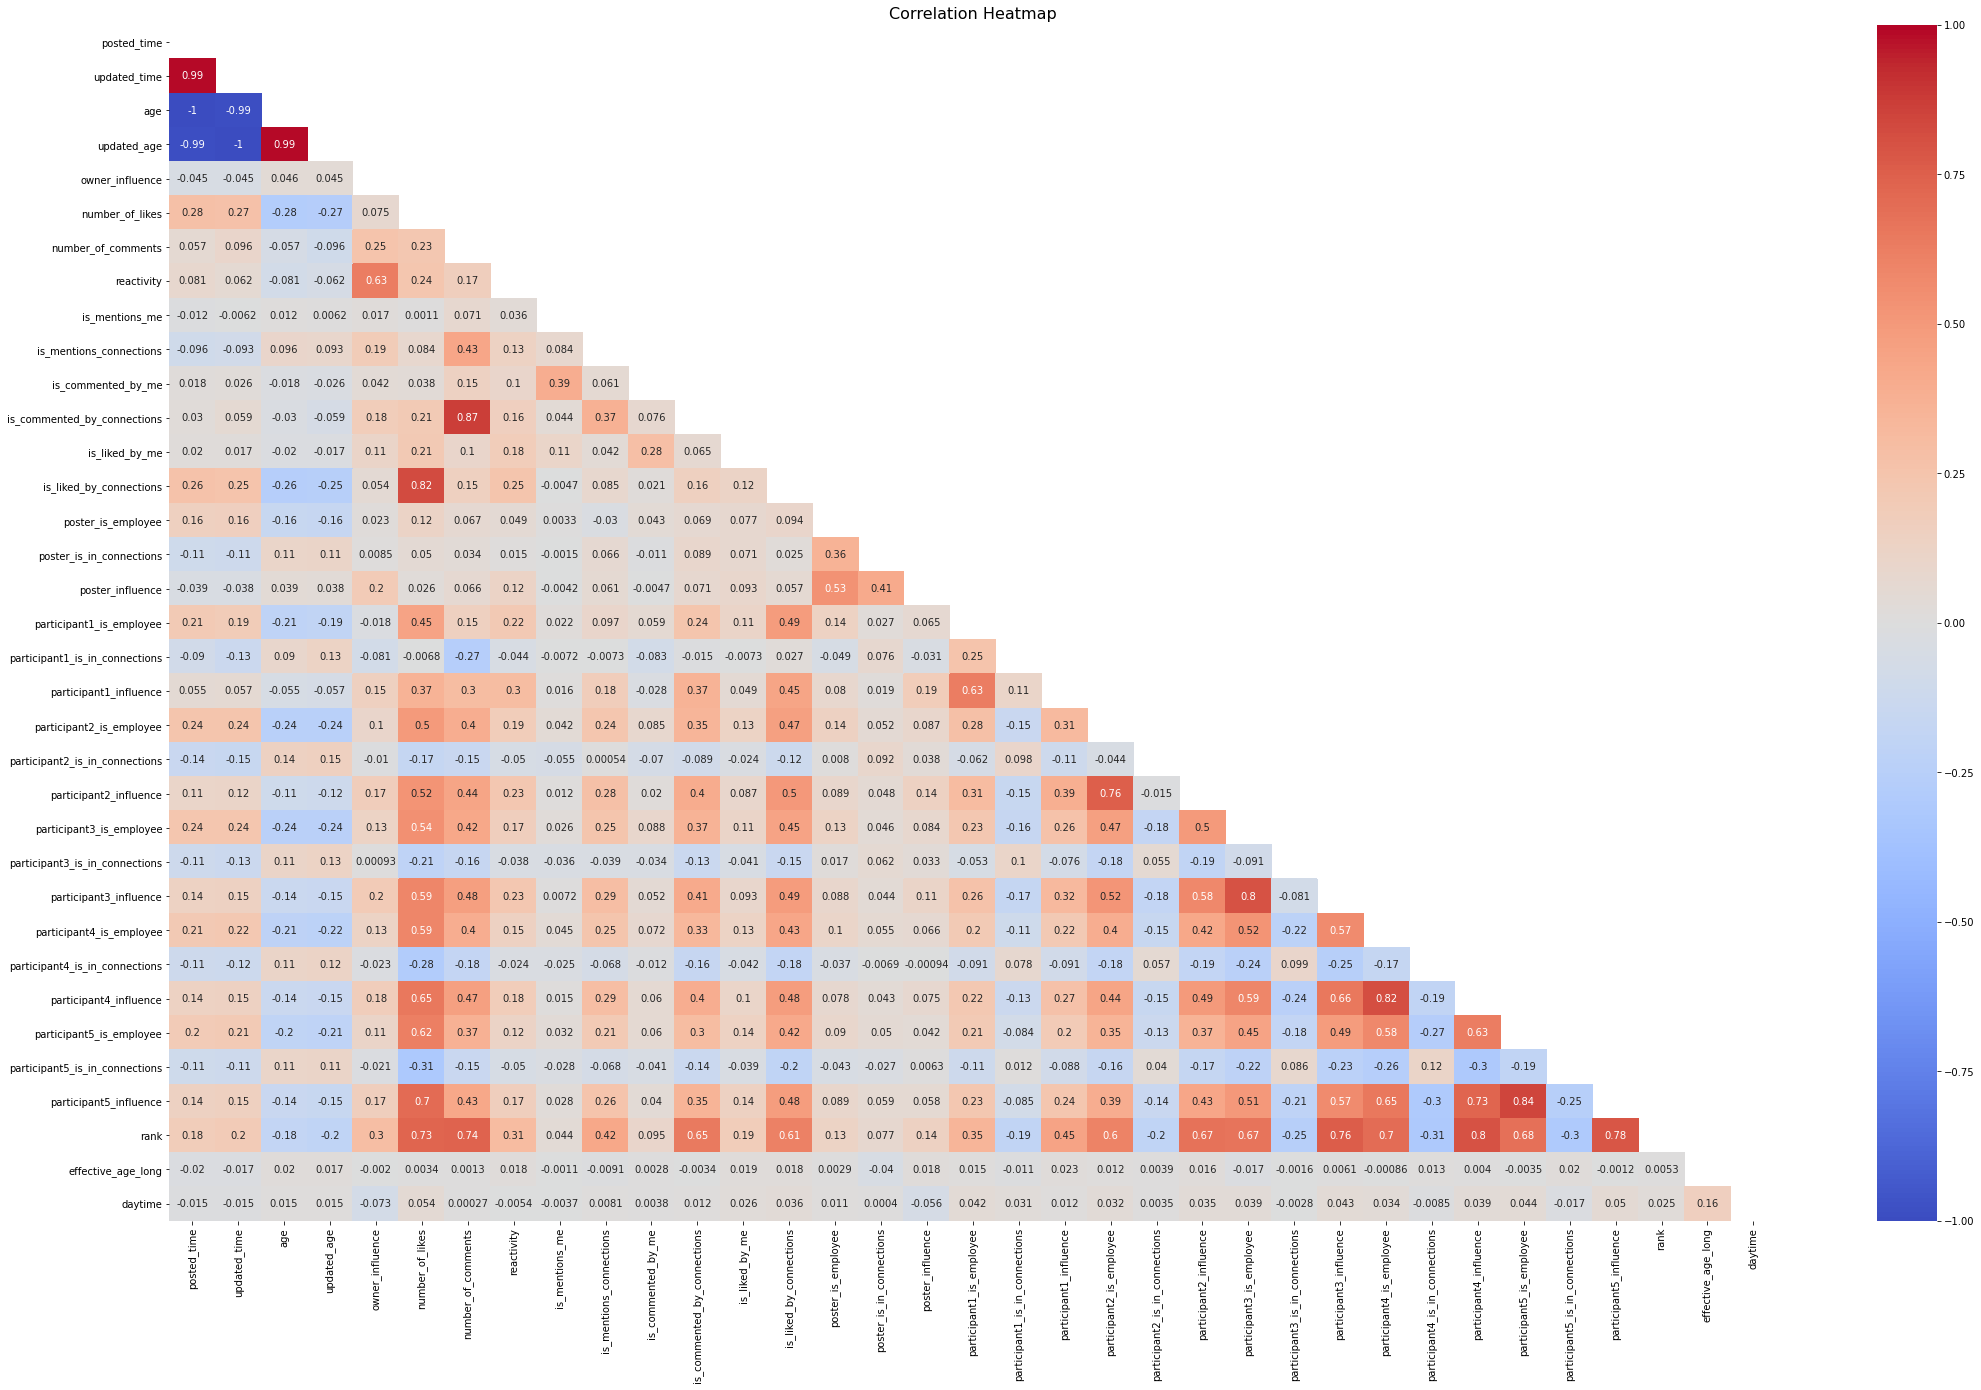

In [78]:
plot_corr_matrix(tmp_df, "spearman")